In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
#pip install hdbscan
import hdbscan


train_set = pd.read_csv('data/clean_data.csv')

X = train_set.copy()


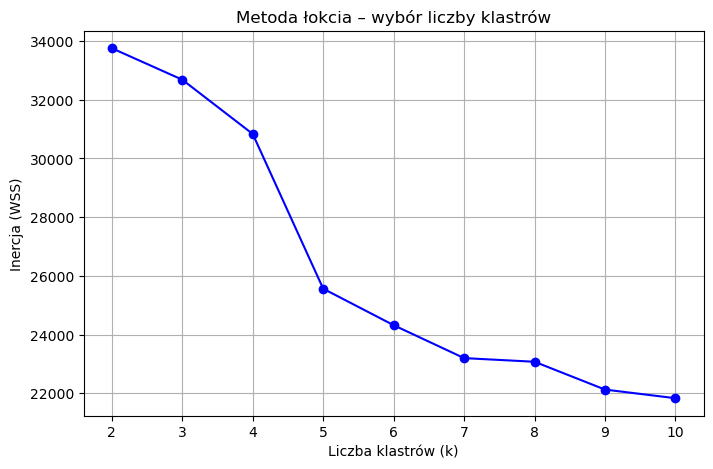

In [2]:


X_elbow = train_set.copy()
X_elbow = X_elbow.select_dtypes(include='number').drop(columns=['Cluster', 'PCA1', 'PCA2'], errors='ignore')

inertia = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_elbow)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Liczba klastrów (k)')
plt.ylabel('Inercja (WSS)')
plt.title('Metoda łokcia – wybór liczby klastrów')
plt.grid(True)
plt.show()


In [3]:
from sklearn.cluster import KMeans

k = 5
X = train_set.copy()
kmeans = KMeans(n_clusters=k, random_state=42)
X['Cluster'] = kmeans.fit_predict(X)


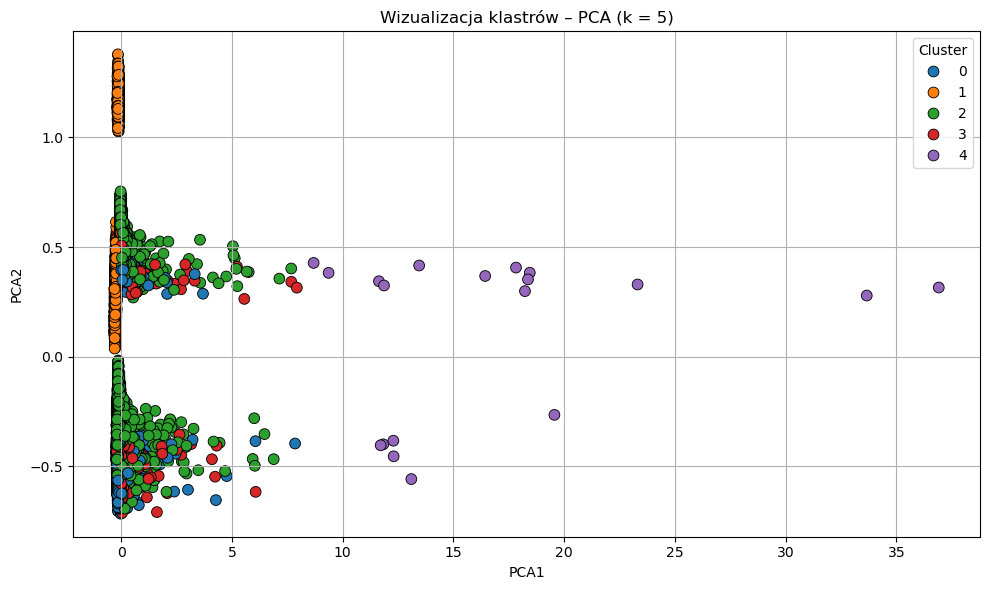

In [4]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

X_pca_input = X.drop(columns='Cluster')
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_pca_input)

X['PCA1'] = X_pca[:, 0]
X['PCA2'] = X_pca[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=X,
    x='PCA1',
    y='PCA2',
    hue='Cluster',
    palette='tab10',
    s=60,
    edgecolor='black'
)
plt.title(f'Wizualizacja klastrów – PCA (k = {k})')
plt.grid(True)
plt.tight_layout()
plt.show()


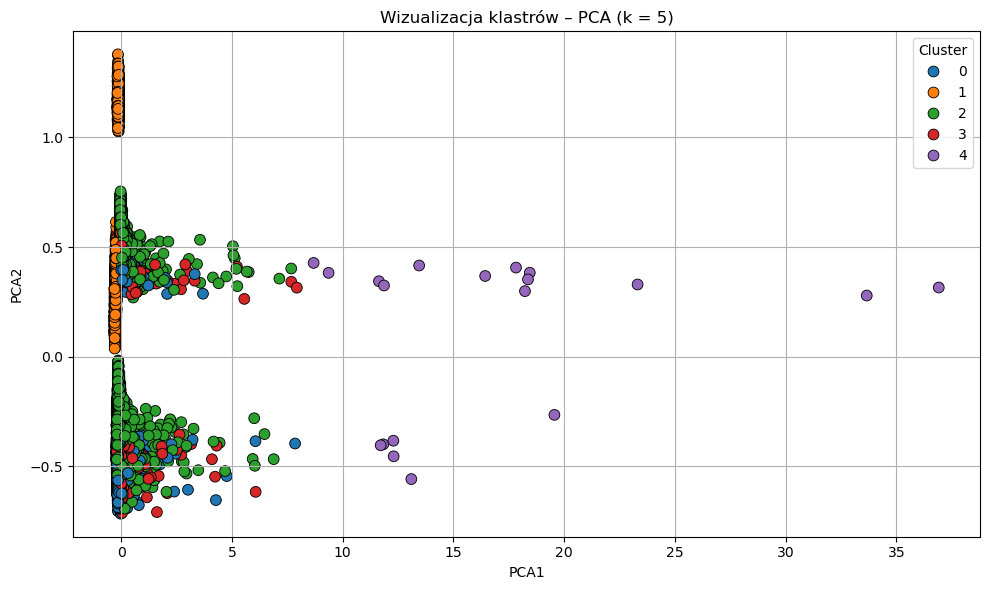

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=X,
    x='PCA1',
    y='PCA2',
    hue='Cluster',
    palette='tab10',
    s=60,
    edgecolor='black'
)
plt.title(f'Wizualizacja klastrów – PCA (k = {k})')
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

X_scaled = X.drop(columns=['Cluster', 'PCA1', 'PCA2'])

sil_score = silhouette_score(X_scaled, X['Cluster'])
db_score = davies_bouldin_score(X_scaled, X['Cluster'])

print(f"Silhouette Score: {sil_score:.3f} ")
print(f"Davies-Bouldin Score: {db_score:.3f} ")


Silhouette Score: 0.100 
Davies-Bouldin Score: 2.251 


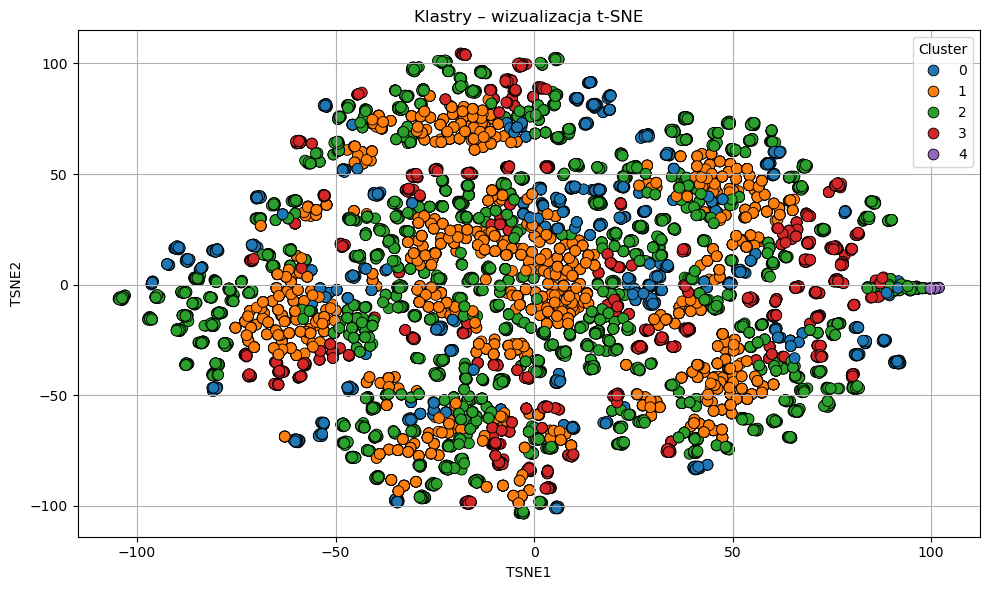

In [7]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

X['TSNE1'] = X_tsne[:, 0]
X['TSNE2'] = X_tsne[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=X,
    x='TSNE1',
    y='TSNE2',
    hue='Cluster',
    palette='tab10',
    s=60,
    edgecolor='black'
)
plt.title('Klastry – wizualizacja t-SNE')
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
#pip install hdbscan


In [9]:
import hdbscan
X_hdbscan = X.drop(columns=['Cluster', 'PCA1', 'PCA2', 'TSNE1', 'TSNE2'], errors='ignore')

# Model HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=30, min_samples=5)
X['HDBSCAN_Cluster'] = clusterer.fit_predict(X_hdbscan)


In [10]:
X['HDBSCAN_Cluster'].value_counts()


HDBSCAN_Cluster
 2    7376
 1    1262
 0    1162
-1     200
Name: count, dtype: int64

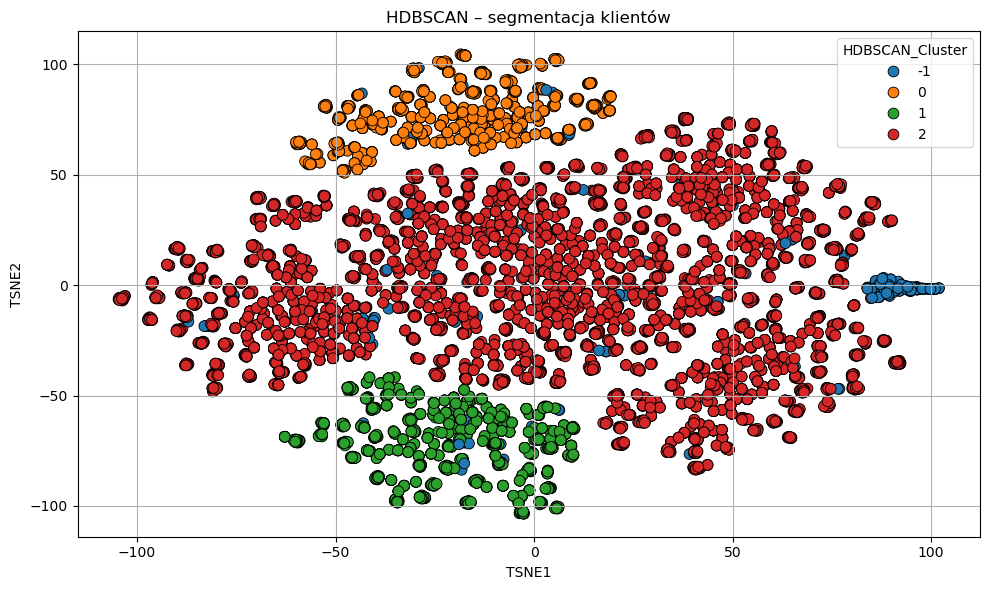

In [11]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=X,
    x='TSNE1',  # lub 'PCA1'
    y='TSNE2',  # lub 'PCA2'
    hue='HDBSCAN_Cluster',
    palette='tab10',
    s=60,
    edgecolor='black'
)
plt.title('HDBSCAN – segmentacja klientów')
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
# Grupowanie po HDBSCAN_Cluster
profile = X.groupby('HDBSCAN_Cluster').mean().round(2)
print(profile.T)  


HDBSCAN_Cluster                                        -1          0  \
Transaction Amount                               0.690000   0.500000   
Account Balance                                  0.010000   0.520000   
Transaction_To_Balance_Ratio                     3.990000   0.100000   
Branch_Size                                      0.650000   0.000000   
Is_High_Value_Transaction                        0.440000   0.250000   
High_Balance_flag                                0.000000   0.270000   
Branch_Houston                                   0.120000   0.000000   
Branch_Los Angeles                               0.130000   0.000000   
Branch_New York                                  0.120000   0.000000   
Branch_Philadelphia                              0.130000   0.000000   
Branch_Phoenix                                   0.140000   0.000000   
Branch_San Antonio                               0.160000   0.000000   
Branch_San Diego                                 0.100000   1.00

In [13]:
X_no_branch = X.drop(columns=[col for col in X.columns if col.startswith('Branch_') or col.startswith('TSNE') or col.startswith('PCA') or col == 'Cluster' or col == 'HDBSCAN_Cluster'])


In [14]:

clusterer = hdbscan.HDBSCAN(min_cluster_size=30, min_samples=5)
X['HDBSCAN_PURE'] = clusterer.fit_predict(X_no_branch)


C:\Users\Stefan\AppData\Local\Temp\ipykernel_5724\2640158480.py:6: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


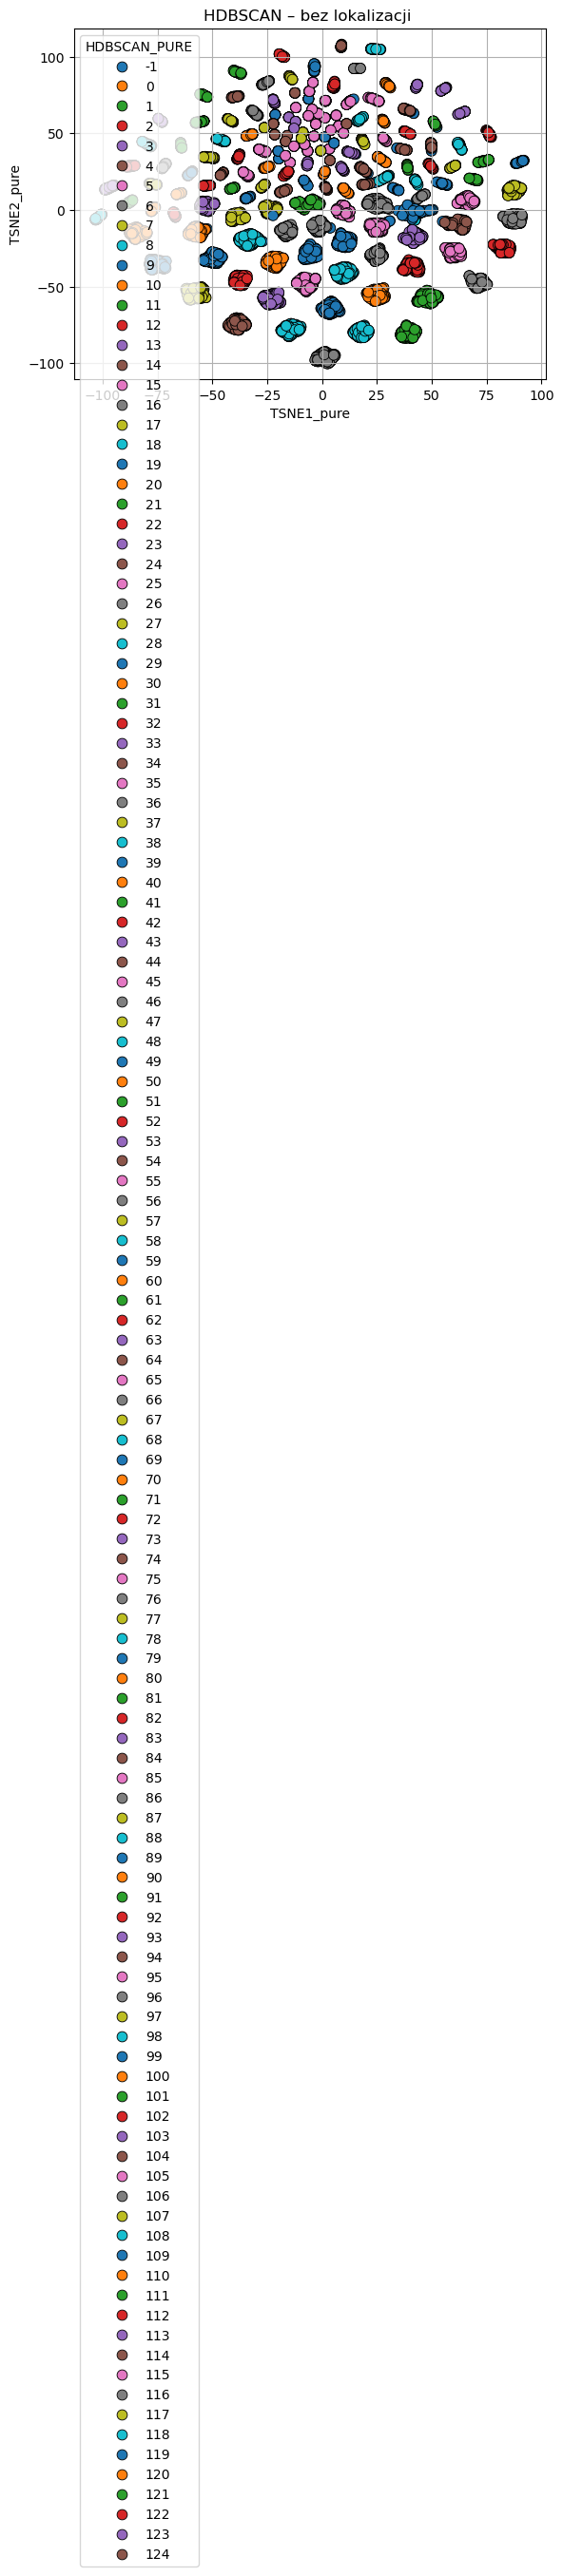

In [15]:
X['TSNE1_pure'], X['TSNE2_pure'] = TSNE(n_components=2, random_state=42).fit_transform(X_no_branch).T

sns.scatterplot(data=X, x='TSNE1_pure', y='TSNE2_pure', hue='HDBSCAN_PURE', palette='tab10', s=60, edgecolor='black')
plt.title('HDBSCAN – bez lokalizacji ')
plt.grid(True)
plt.tight_layout()
plt.show()


### Znajdowało jedynie klastry odpowiedzialne za lokalizacje (branch) nie na tym nam zależy więc pozbądźmy się go

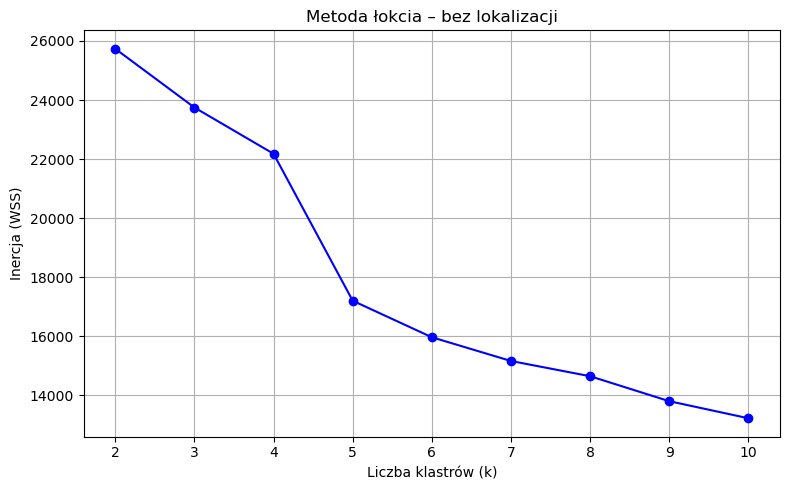

In [17]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

X_elbow = X.drop(columns=[col for col in X.columns if col.startswith('Branch_') or col.startswith('TSNE') or col.startswith('PCA') or col.startswith('Cluster') or col.startswith('HDBSCAN')])

inertia = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_elbow)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Liczba klastrów (k)')
plt.ylabel('Inercja (WSS)')
plt.title('Metoda łokcia – bez lokalizacji')
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
from sklearn.cluster import KMeans

X_kmeans = X.drop(columns=[col for col in X.columns if col.startswith('Branch_') or col.startswith('TSNE') or col.startswith('PCA') or col.startswith('Cluster') or col.startswith('HDBSCAN')])

# KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
X['KMeans_NoLocation'] = kmeans.fit_predict(X_kmeans)


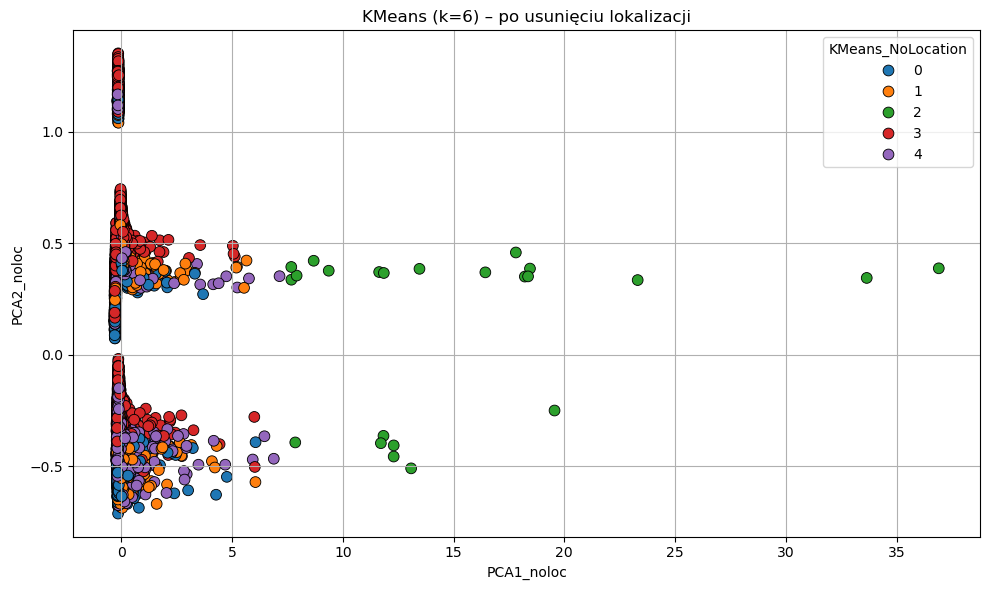

In [19]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_kmeans)

X['PCA1_noloc'] = X_pca[:, 0]
X['PCA2_noloc'] = X_pca[:, 1]

# Wykres
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=X,
    x='PCA1_noloc',
    y='PCA2_noloc',
    hue='KMeans_NoLocation',
    palette='tab10',
    s=60,
    edgecolor='black'
)
plt.title('KMeans (k=6) – po usunięciu lokalizacji')
plt.grid(True)
plt.tight_layout()
plt.show()


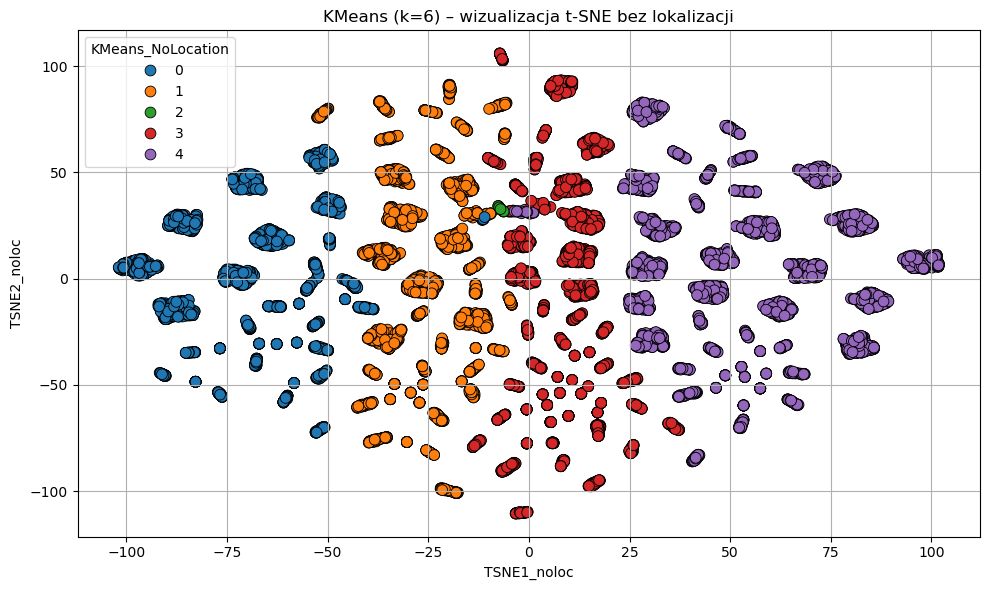

In [20]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

X_tsne_input = X.drop(columns=[col for col in X.columns if col.startswith('Branch_') or col.startswith('TSNE') or col.startswith('PCA') or col.startswith('Cluster') or col.startswith('HDBSCAN')])

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_tsne_input)

X['TSNE1_noloc'] = X_tsne[:, 0]
X['TSNE2_noloc'] = X_tsne[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=X,
    x='TSNE1_noloc',
    y='TSNE2_noloc',
    hue='KMeans_NoLocation',
    palette='tab10',
    s=60,
    edgecolor='black'
)
plt.title('KMeans (k=6) – wizualizacja t-SNE bez lokalizacji')
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
X_kmeans['KMeans_NoLocation'] = X['KMeans_NoLocation']

profile = X_kmeans.groupby('KMeans_NoLocation').mean().round(2)
profile.T


KMeans_NoLocation,0,1,2,3,4
Transaction Amount,0.50,0.56,0.78,0.51,0.46
Account Balance,0.50,0.48,0.00,0.59,0.46
Transaction_To_Balance_Ratio,0.13,0.16,15.43,0.12,0.14
Is_High_Value_Transaction,0.24,0.36,0.70,0.26,0.16
High_Balance_flag,0.24,0.21,0.00,0.42,0.15
Account_Transaction_Current - Debit,0.13,0.12,0.17,0.12,0.12
Account_Transaction_Fixed Deposit - Credit,0.12,0.13,0.09,0.14,0.12
Account_Transaction_Fixed Deposit - Debit,0.13,0.12,0.09,0.12,0.13
Account_Transaction_Recurring Deposit - Credit,0.12,0.13,0.09,0.12,0.12
Account_Transaction_Recurring Deposit - Debit,0.11,0.12,0.04,0.12,0.13


Ponownie znajduje jedynie zależności względem waluty, nam zależy przede wszystkim na modelowaniu działalności klientów a nie walut z jakich korzystają
Zrobimy feature engineering 2 w którym spróbujemy pozbyć się zarówno lokalizacji jak i waluty, pozostawimy jedynie informację czy waluta to USD